In [49]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import plotly
plotly.tools.set_credentials_file(username='cohenk2', api_key='dF6eJ0G0zN5JH3ifD1sH')
import plotly.plotly as py
import plotly.figure_factory as ff
from sklearn.tree import export_graphviz
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
%matplotlib inline

# Classification

Since our regression model on the full data set yielded poor results at predicting the number of followers a playlist would have, we thought a useful approach would be to see if classification of a playlist as successful or not (as defined by being in the top quartile of playlists in terms of number of followers) would be more useful.

In terms of metrics to be used for classification, we look both at classification accuracy, AUC, as well as true positive and true negative rates. The AUC and the confusion matrix are the best indication of the success of the classifier, because they highlight the tradeoff between true positives and false positives, true negatives and false negatives, and the shortcomings of using classification accuracy alone in an unbalanced dataset like this one where there are few true positives to detect.  

In [9]:
train_data = pd.read_csv('train_data.csv')
train_data = train_data.fillna(0)
train_data = train_data.replace([np.inf, -np.inf], 0)

In [10]:
train_data.columns

Index(['Unnamed: 0', 'playlist', 'name', 'followers', 'num_songs',
       'av_song_pop', 'pct_explicit', 'avg_dur', 'av_artist_followers',
       'pop_pct',
       ...
       'Post Malone*rap_pct', 'Post Malone*rock_pct',
       'Post Malone*hip_hop_pct', 'Post Malone*country_pct',
       'Post Malone*metal_pct', 'Post Malone*indie_folk_pct',
       'Post Malone*rnb_pct', 'Post Malone*edm_pct',
       'Post Malone*classical_pct', 'Post Malone*jazz_pct'],
      dtype='object', length=514)

In [11]:
del train_data['Unnamed: 0']

In [15]:
top_quart = train_data['followers'].quantile(0.75)
train_data['pop_or_not'] = np.where(train_data['followers'] >= top_quart, 1, 0)
y_data = train_data['pop_or_not']
x_data = train_data.drop(['followers','pop_or_not', 'playlist', 'name'], axis =1)

In [16]:
train_data.isnull().values.any()

False

## Classification Models

### Model 1 – Logistic Regression with L2 Penalization (Baseline model)

The first baseline model that we preformed for classification was Logistic Regression cross validated with an L2 penalizaiton factor. This model works by calculating the degree to which each predictor affect the log odds of the probability of being successful or not. The log odds is calculated by: log$\left(\dfrac{p}{1-p}\right)$, with p being the probability of a playlist being successful. L2 regularization means that we are attempting to account for overfitting by providing a penalization factor, and is cross validated to give us a sense of accuracy on out of sample observations. This yields a classificaiton accuracy on the train set of $\bf{.77}$, and an AUC of $\bf{.57}$. 

In [108]:
ind_train, ind_val = train_test_split(range(train_data.shape[0]), train_size=0.75)

#x's
x_train = pd.concat([x_data.iloc[ind_train, :]])
x_val = pd.concat([x_data.iloc[ind_val, :]])

#y's
y_train = y_data.iloc[ind_train]
y_val = y_data.iloc[ind_val]

# logistic Regression Classifier with L2
log_cv = LogisticRegressionCV() # Uses cross-validation for given C's and L2 penalty by default
log_cv.fit(x_train, y_train)
pred = log_cv.predict(x_val)
print('CV Train Accurcay', log_cv.score(x_train, y_train))
print('CV Test Accuracy', log_cv.score(x_val, y_val))

print('Area under the curve full logistic:', roc_auc_score(y_train, log_cv.predict(x_train)))
confusion_matrix(y_train, log_cv.predict(x_train))

CV Train Accurcay 0.773220747889
CV Test Accuracy 0.743682310469
Area under the curve full logistic: 0.578785306374


array([[602,  18],
       [170,  39]])

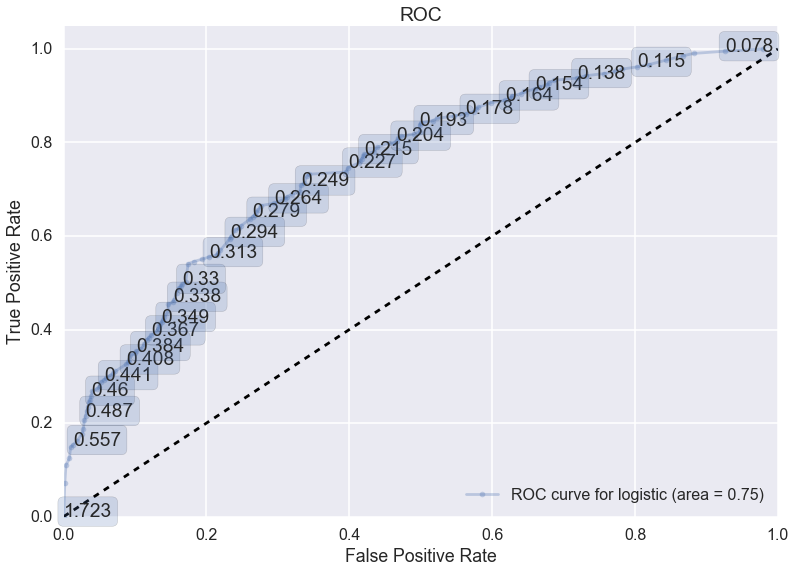

In [116]:
# Using the code from lab to generate the roc curve
from sklearn.metrics import roc_curve, auc

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:# For stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
        #print(fpr, tpr)
    else:# For stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 3))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

sns.set_context("poster")
# Cross validated logistic regression
ax=make_roc("logistic",log_cv, y_train, x_train, labe=10, skip=2)

### Model 2 – PCA

Though we use an L2 penalizaiton factor in an attempt to prevent overfitting in the simple logistic regression above, our model still has many predictors (roughly 500), and thus there’s risk of overfitting. Overfitting occurs when our model is highly complex and begins to model the noise in our data due to randomness alone. In addition, there is also potential to overfit since there is so much variation in what creates a successful playlist. One tactic to try and avoid overfitting is to reduce the number of predictors using a process known as Principal Component Analysis, or PCA. PCA attempts to explain the variance observed in our data using features. Each feature is a linear combination of a subset of the predictors; ideally we are able to explain a large amount of the variance with as few features as possible.

In the end, PCA was comparable to the full logistic regression in terms of predictive power, with an AUC of $\bf{.56}$ and a train classification accuracy of $\bf{.76}$


In [21]:
# pca

accuracy_train_cv = np.zeros((25,10))
accuracy_valid_cv = np.zeros((25,10))

fold_ctr = 0

for itrain, ivalid in KFold(n_splits=10, shuffle=True, random_state=9001).split(x_data.index):
    # in general though its good for creating consistent psets, don't put seeds into kfold
    # split
    X_train_cv = x_data.iloc[itrain,:]
    y_train_cv = y_data.iloc[itrain]
    X_valid_cv = x_data.iloc[ivalid,:]
    y_valid_cv = y_data.iloc[ivalid]
    
    # pca
    pca = PCA()
    pca.fit(X_train_cv)
    X_train_pca_cv = pca.transform(X_train_cv)
    X_valid_pca_cv = pca.transform(X_valid_cv)
    
    for comp in range(1,25):
        # fit logit
        logregcv = LogisticRegression(C=100000, fit_intercept=True)
        logregcv.fit(X_train_pca_cv[:,:comp], y_train_cv)
        
        # get predictions
        yhat_train_pca_cv = logregcv.predict(X_train_pca_cv[:,:comp])
        yhat_valid_pca_cv = logregcv.predict(X_valid_pca_cv[:,:comp])
        
        # get accuracy       
        accuracy_train_cv[comp,fold_ctr] = accuracy_score(y_train_cv, yhat_train_pca_cv)
        accuracy_valid_cv[comp,fold_ctr] = accuracy_score(y_valid_cv, yhat_valid_pca_cv)
        
    fold_ctr += 1

In [102]:
scores_valid = np.mean(accuracy_valid_cv, axis=1)[1:]
scores_train = np.mean(accuracy_train_cv, axis=1)[1:]

# choose optimum as smallest number of components "sufficiently" close to maximum validation accuracy
for i in range(len(scores_valid)):
    if np.max(scores_valid)-scores_valid[i]<0:
        n_components_optimal=i+1
        break

best_cv = range(1, 25)[np.argmax(scores_valid)]

pca = PCA(n_components=best_cv)
pca.fit(x_train)
x_train_pca_best = pca.transform(x_train)
x_val_pca_best = pca.transform(x_val)
logreg_pca = LogisticRegression(fit_intercept = True)
logreg_pca.fit(x_train_pca_best, y_train)
pred_pca_cv = logreg_pca.predict(x_val_pca_best)

print('optimal number of components is:', best_cv)
print('Train Classification Accuracy: {}'.format(logreg_pca.score(x_train_pca_best, y_train)))
print('Test Classification Accuracy: {}'.format(logreg_pca.score(x_val_pca_best, y_val)))
print('Area under the curve CV PCA:', roc_auc_score(y_val, pred_pca_cv))
confusion_matrix(y_train, logreg_pca.predict(x_train_pca_best))

optimal number of components is: 17
Train Classification Accuracy: 0.7635705669481303
Test Classification Accuracy: 0.7509025270758123
Area under the curve CV PCA: 0.55217421897


array([[591,  29],
       [167,  42]])

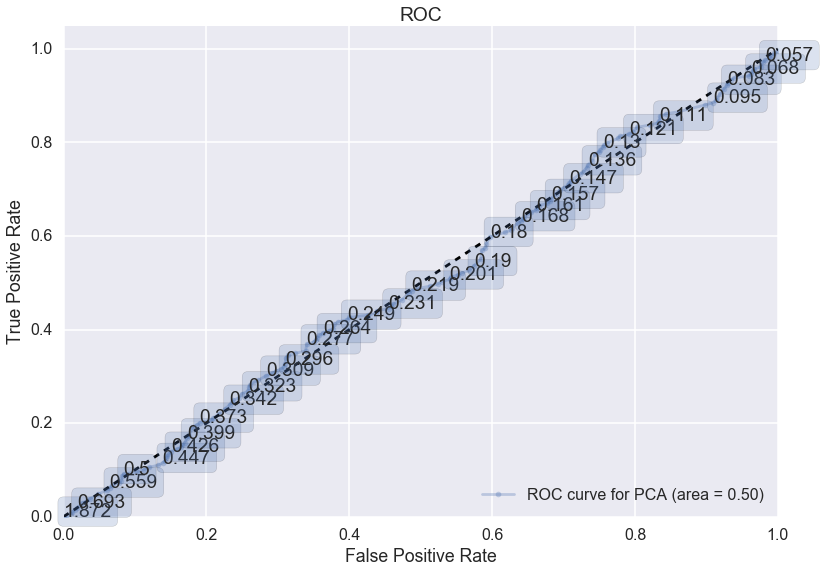

In [117]:
ax=make_roc("PCA",logreg_pca, y_train, x_train_pca_best, labe=10, skip=2)

### Model 3 – Decision Tree

A third classification model that we attempted to impliment was the decision tree classifier. We thought this would be a particularly promising model to try because of it's interpretability both to us and Spotify in terms of business applicability. The way decision trees work is by classifying through making cutoffs with certain predictors, in essence saying that for certain values of combinations of predictors indicate a "positive" (successful playlist in this case), and other are indicative of a negative (unsuccessful playlist). 

We cross validated the optimal depth of the tree to be 2 decisions (indicating that few predictors are significant towards predicting playlist significance), and saw an AUC of $\bf{.61}$ and train classification accuracy of $\bf{.76}$. 

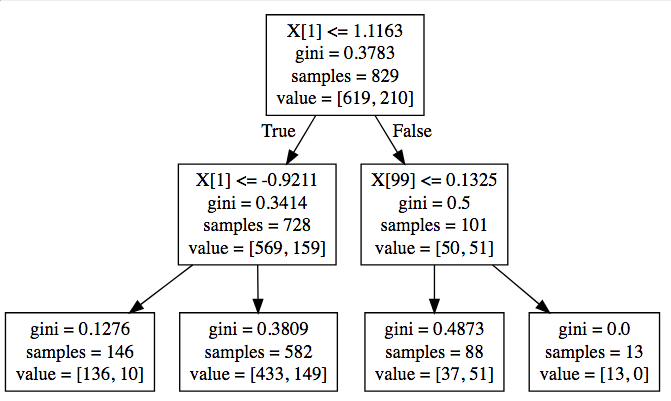

In [65]:
from IPython.display import Image
Image(filename='tree.png')

In [104]:
# decision tree

# Cross Validation
cv_scores = []
depths = list(range(2,15))

# Perform 5-fold cross validation
for depth in depths:
    tree_cv = DecisionTreeClassifier(max_depth = depth)
    tree_cv.fit(x_train, y_train)
    scores = cross_val_score(tree_cv, x_train, y_train, cv = 5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Determining best depth
optimal_depth = depths[cv_scores.index(max(cv_scores))]
print('The optimal tree depth is:', optimal_depth)
tree_cv_final = DecisionTreeClassifier(max_depth = optimal_depth)
tree_cv_final.fit(x_train, y_train)
tree_pred = tree_cv_final.predict(x_val)
print("Tree Depth",optimal_depth, "Train Score: ",tree_cv_final.score(x_train,y_train))
print("Tree Depth",optimal_depth, "Test Score: ",tree_cv_final.score(x_val,y_val))
print('Area under the curve decision tree:', roc_auc_score(y_val, tree_pred))
print(confusion_matrix(y_train, tree_cv_final.predict(x_train)))
export_graphviz(tree_cv_final)

The optimal tree depth is: 2
Tree Depth 2 Train Score:  0.768395657419
Tree Depth 2 Test Score:  0.758122743682
Area under the curve decision tree: 0.561919504644
[[584  36]
 [156  53]]


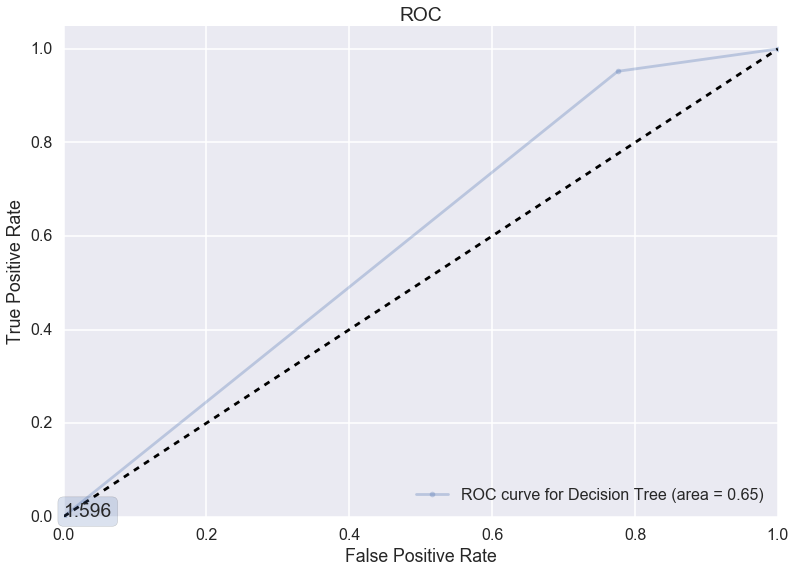

In [118]:
ax=make_roc("Decision Tree",tree_cv_final, y_train, x_train, labe=10, skip=2)

In [90]:
tree_cv_final.feature_importances_


array([ 0.        ,  0.74956889,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

### Model 4 – KNN

KNN works in classification by attempting to detect clusters in the data via proximity to other similar data points. In data that is clearly defined, or well separated, this is a particularly powerful tool because distance between points contains a lot of information as to how the observations should ultimately be classified. The limitations of the model in predicting song followers is that due to the subjectivity of any playlist and the variability of what constitutes a successful playlist, even when genre is controlled for, it is unlikely that all successful clusters would be well separated into "successful" and "unsuccessful" playlists. 

Because of this, it is unsurprising that KNN is the worst preformance of the models thus far, with a train prediction accuracy of $\bf{.78}$ and an AUC of $\bf{.52}$. 

In [106]:
#knn

neighbors = list(range(1,50))
cv_scores = []

# Perform 10-fold cross validation
for k in neighbors:
    knn = KNN(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# Determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
knn = KNN(n_neighbors = optimal_k)
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_val)

print("KNN", optimal_k,"Train: ",knn.score(x_train, y_train))
print("KNN", optimal_k,"Test: ",knn.score(x_val, y_val))
print('Area under the curve knn:', roc_auc_score(y_val, knn_pred))
confusion_matrix(y_train, knn.predict(x_train))

KNN 8 Train:  0.797346200241
KNN 8 Test:  0.718411552347
Area under the curve knn: 0.540564311849


array([[594,  26],
       [142,  67]])

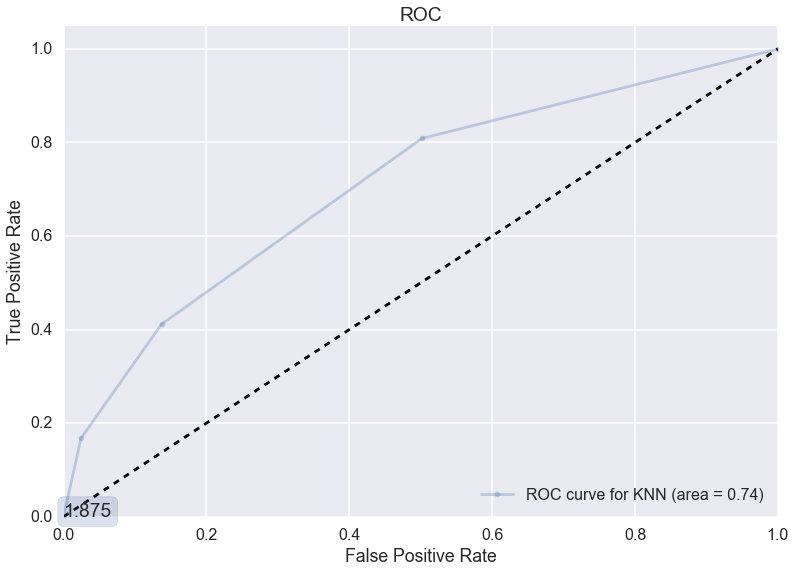

In [119]:
ax=make_roc("KNN",knn, y_train, x_train, labe=10, skip=2)

### Model 5  – Random Forrest

A random forrest is a particularly useful extension of the decision tree. It is an ensemble method in which many independent decision trees are constucted by bootstrapping predictors and taking a random sample of predictors to be used in each tree to form a "random forrest". This is often able to out preform a single decision tree by finding new combinations of trees with different leaves in order to improve prediction accuracy. 

The random forrest surprisingly did not do as well as the single decision tree, with an AUC of and a classification accuracy of . Because we see that the optimal number of trees in the random forrest is only 2, meaning that there isn't a substantial improvement by having more than a single decision tree, this result is not surprising. This is consistent with above findings that very few predictors end up being significant in predicting playlist success. 

FILL IN THE AUC

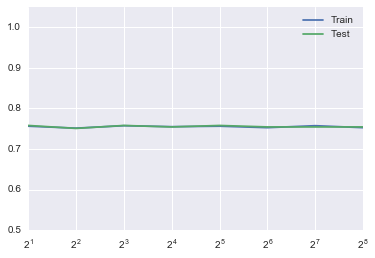

In [86]:
# random forrest
trees = [2,4,8,16,32,64,128,256]
rf_train_score = []
rf_test_score = []
rf_oob = []

for tree in trees:
    rf = RandomForestClassifier(n_estimators = tree, oob_score = True, max_depth = 2)
    rf.fit(x_train,y_train)
    rf_train_score.append(rf.score(x_train,y_train))
    rf_test_score.append(rf.score(x_val,y_val))
    rf_oob.append(rf.oob_score_)
    
plt.figure()
plt.xscale('log',basex = 2)
plt.ylim(0.5,1.05)
plt.plot(trees,rf_train_score, label = "Train")
plt.plot(trees,rf_test_score, label = "Test")
plt.legend()
plt.show()

In [87]:
# Fixing Trees to 32 w/ cross validation
cv_scores = []
predictors = list(range(2,len(x_train.columns)+1))

# Perform 5-fold cross validation
for predictor in predictors:
    feat = int(predictor)
    rf_cv = RandomForestClassifier(n_estimators = 2, oob_score = True, max_features = feat, max_depth = 2)
    rf_cv.fit(x_train,y_train)
    scores = cross_val_score(rf_cv, x_train, y_train, cv = 5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Determining best # of predictors
optimal_predictors = predictors[cv_scores.index(max(cv_scores))]
print("The ideal # of predictors with 2 trees is:",optimal_predictors)

The ideal # of predictors with 2 trees is: 302


In [88]:
# test performance at optimal # of predictors
predictor_opt = max(cv_scores)
rf_opt = RandomForestClassifier(n_estimators = 2, oob_score = True, max_features = predictor_opt, max_depth = 2)
rf_opt.fit(x_train, y_train)
rf_pred = rf_opt.predict(x_val)
cv_score_test = cross_val_score(rf_opt, x_val, y_val, cv = 5, scoring = 'accuracy')
print("Test accuracy:", np.mean(cv_score_test))
print('Area under the curve:', roc_auc_score(y_val, rf_pred))
confusion_matrix(y_train, rf_opt.predict(x_train))

Test accuracy: 0.75461038961
Area under the curve: 0.54065387349


array([[596,  23],
       [169,  41]])

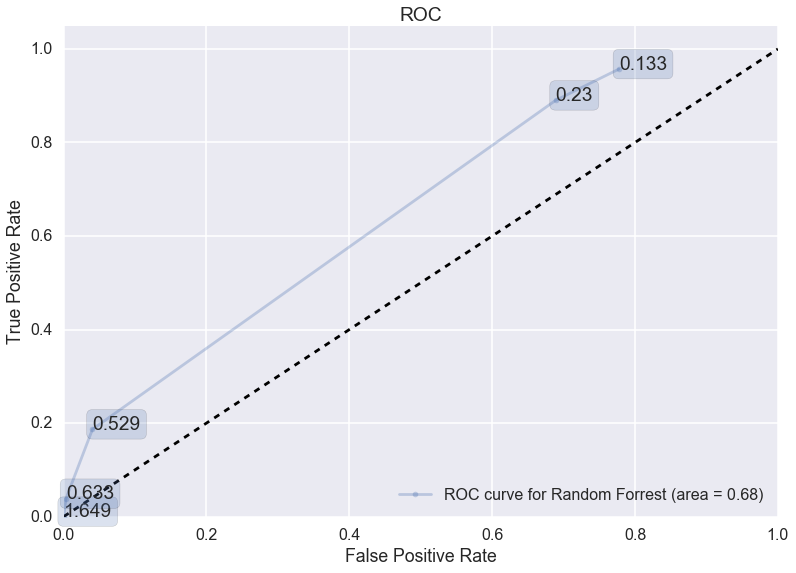

In [120]:
ax=make_roc("Random Forrest",rf_opt, y_train, x_train, labe=2, skip=2)

In [85]:
cols = x_train.columns

predicts = pd.DataFrame(index = range(0,len(cols)), columns = ['pred', 'weight'])
predicts['pred'] = cols
predicts['weight'] = rf_opt.feature_importances_
sig_preds = predicts[predicts['weight'] != 0]
sig_preds

,pred,weight
0,num_songs,0.445926
1,av_song_pop,0.054164
19,top_3_song_avg_pop,0.240874
22,top_artist_followers,0.200524
37,Kygo,0.058513


In [91]:
data_matrix = [['Model Type', 'AUC Score','Confusion Matrix','Hyperparameters'],
               ['Simple Logistic CV', 0.52, confusion_matrix(y_train, log_cv.predict(x_train)), 'L2 Regularization'],
               ['KNN', .52 , confusion_matrix(y_train, knn.predict(x_train)), 'Optimal # of neighbors = 12'],
               ['PCA', 0.56, confusion_matrix(y_train, logreg_pca.predict(x_train_pca_best)), 'Optimal # of components '],
               ['Decision Tree', 0.61, confusion_matrix(y_train, tree_cv_final.predict(x_train)), 'Optimal Tree Depth = 2'],
               ['Random Forrest', 0.132, 'Unlikely', 'Optimal # of Trees = 2, Optimal # of Predictors = xx']]

table = ff.create_table(data_matrix)
py.iplot(table, filename='class_table')